1. Importing and filepaths

In [1]:
import rasterio
import geopandas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rasterio.io import MemoryFile
import tempfile

import sys
sys.path.insert(0, "..")

from eis_toolkit.exploratory_analyses.basic_plots_seaborn import histogram
from eis_toolkit.vector_processing.idw_interpolation import idw
from eis_toolkit.transformations.logarithmic import _log_transform_ln
from eis_toolkit.transformations.sigmoid import _sigmoid_transform
from eis_toolkit.spatial_analyses.distance_computation import distance_computation
from eis_toolkit.vector_processing.rasterize_vector import rasterize_vector
from eis_toolkit.exploratory_analyses.parallel_coordinates import plot_parallel_coordinates
from eis_toolkit.raster_processing.extract_values_from_raster import extract_values_from_raster
from eis_toolkit.raster_processing.unifying import unify_raster_grids
from eis_toolkit.prediction.fuzzy_overlay import gamma_overlay
from eis_toolkit.prediction.weights_of_evidence import weights_of_evidence_calculate_weights, weights_of_evidence_calculate_responses
from eis_toolkit.validation.calculate_auc import calculate_auc
from eis_toolkit.validation.plot_rate_curve import plot_rate_curve
from eis_toolkit.validation.plot_prediction_area_curves import plot_prediction_area_curves

In [2]:
# Define filepaths
AEM_inphase_fp = "../tests/data/remote/workflow_demo/IOCG_AEM_Inph_.tif"
AEM_quad_fp = "../tests/data/remote/workflow_demo/IOCG_AEM_Quad.tif"
AEM_ratio_fp = "../tests/data/remote/workflow_demo/IOCG_EM_ratio.tif"
Magn_AS_fp = "../tests/data/remote/workflow_demo/Mag_DGRF_AS_FFT_ers_PCS_tif_clip.tif"

till_geochem_fp = "../tests/data/remote/workflow_demo/Geochemical_Data/Vector_files/IOCG_CLB_Till_Geochem_reg_511p.shp"
structures_fp = "../tests/data/remote/workflow_demo/Geological_Data/IOCG_CLB_Structures_1M.shp"
lithology_fp = "../tests/data/remote/workflow_demo/Geological_Data/IOCG_CLB_Lith_Asstn_1M.shp"
known_occurances_fp = "../tests/data/remote/workflow_demo/Deposits_Occurrences/IOCG_Deps_Prosp_Occs.shp"

In [3]:
# Take AEM_inphase raster profile and grid shape as the base/target
with rasterio.open(AEM_inphase_fp) as AEM_inphase:
    raster_profile = AEM_inphase.profile
    raster_extent = AEM_inphase.bounds
    raster_pixel_size = AEM_inphase.transform[0]  # Assume square pixels
    print(raster_profile)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -1.0000000331813535e+32, 'width': 1361, 'height': 1642, 'count': 1, 'crs': CRS.from_epsg(3067), 'transform': Affine(50.0, 0.0, 345975.0,
       0.0, -50.0, 7540125.0), 'blockxsize': 128, 'blockysize': 128, 'tiled': True, 'compress': 'lzw', 'interleave': 'band'}


2. Preprocess data

In [4]:
# 2.a. Preprocess geochemical data
till_geochem = geopandas.read_file(till_geochem_fp)

columns_to_process = ["Fe_ppm_511", "Co_ppm_511", "Cu_ppm_511"]

interpolation_results = {}
interpolation_extent = (raster_extent[0], raster_extent[2], raster_extent[1], raster_extent[3])  # NOTE: Rasterio's extent order differs from idw's

# Log transform concentrations and interpolate
# NOTE: EIS Toolkit implements transforms only for rasters at the moment
for column in columns_to_process:
    new_col_name = column[:2] + "_log"
    till_geochem[new_col_name] = np.log(till_geochem[column])

    interpolation_results[new_col_name] = idw(till_geochem, new_col_name, (500, 500), interpolation_extent)


/home/niko/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


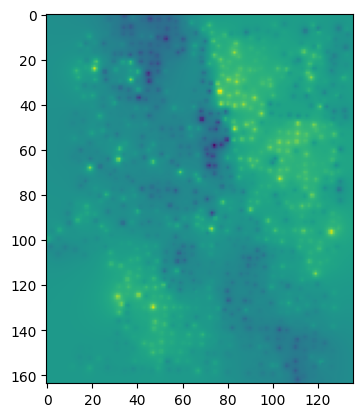

In [5]:
plt.imshow(interpolation_results["Cu_log"][0])

In [6]:
# 2.b. Preprocess geological data
structures = geopandas.read_file(structures_fp)

calculate_distances = False
if calculate_distances:  # Can take quite a while, therefore option to skip
    distances_to_stuctures = distance_computation(raster_profile, structures)

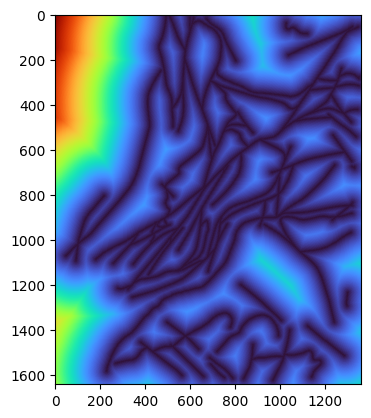

In [7]:
# Visualize distances to structures with matplotlib
plt.imshow(distances_to_stuctures, cmap="turbo")

In [8]:
# Rasterize lithology
lithology = geopandas.read_file(lithology_fp)
rasterized_lithology = rasterize_vector(lithology, base_raster_profile=raster_profile)

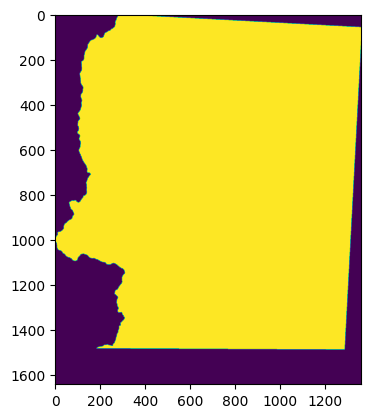

In [9]:
# Visualize lithology with matplotlib
plt.imshow(rasterized_lithology[0])

3-4. Explore data and unify rasters

In [10]:
# 3.a. Extract raster values at deposits
known_occurances = geopandas.read_file(known_occurances_fp)

# Open rasters with context manager, save lithology data to temporary raster file so we can use the extract function on it
with \
    MemoryFile() as memfile, \
    rasterio.open(AEM_inphase_fp) as AEM_inphase, \
    rasterio.open(AEM_quad_fp) as AEM_quad, \
    rasterio.open(AEM_ratio_fp) as AEM_ratio, \
    rasterio.open(Magn_AS_fp) as Magn_AS:

    with tempfile.NamedTemporaryFile() as tmpfile:
        with rasterio.open(tmpfile.name, "w", **raster_profile) as dest:
            dest.write(rasterized_lithology[0], 1)
        with rasterio.open(tmpfile.name) as lithology_raster:
            raster_list = [AEM_inphase, AEM_quad, AEM_ratio, Magn_AS, lithology_raster]
            col_names = ["AEM_inphase", "AEM_quad", "AEM_ratio", "Magn_AS", "Lithology"]
            raster_values_at_deposits = extract_values_from_raster(raster_list, known_occurances, col_names)

            unified_rasters = unify_raster_grids(AEM_inphase, raster_list[1:], same_extent=True)

raster_values_at_deposits

,x,y,AEM_inphase,AEM_quad,AEM_ratio,Magn_AS,Lithology
0,370953.0,7502821.0,-408.969513,369.960022,-1.059486,17.158161,1.0
1,371340.0,7496345.0,3889.745605,2384.806152,1.817769,21.545200,1.0
2,385205.0,7497926.0,-339.839050,187.980026,-1.730280,14.112287,1.0
3,369187.0,7490345.0,1468.369385,1285.413208,1.034502,20.598907,1.0
4,368175.0,7489722.0,537.748718,324.102142,1.903474,43.523659,1.0
5,350043.0,7489418.0,-6.511929,625.734375,0.025980,72.489517,1.0
6,363838.0,7492354.0,-435.950928,248.234833,-1.672447,8.311082,1.0
7,364672.0,7482684.0,-210.937698,1754.664917,-0.309453,31.408430,1.0
8,396649.0,7501845.0,-373.599243,440.641846,-1.192332,12.663096,1.0
9,372344.0,7492293.0,-885.269836,675.116272,-2.274024,8.680225,1.0


<Axes: ylabel='Count'>

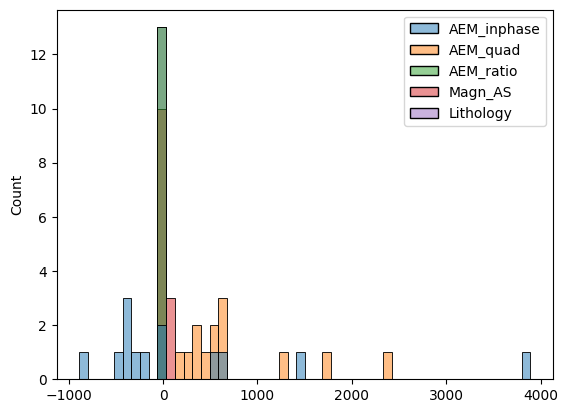

In [11]:
# 3.b. Plot histograms
histogram(raster_values_at_deposits.drop(["x", "y"], axis=1))

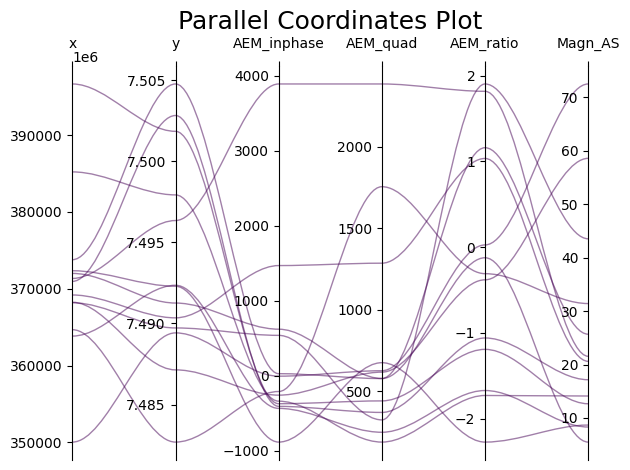

In [12]:
# 3.c. Plot parallel coordinates
fig = plot_parallel_coordinates(raster_values_at_deposits, color_column_name="Lithology", palette_name="viridis")

/home/niko/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1134: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
/home/niko/.local/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:1153: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


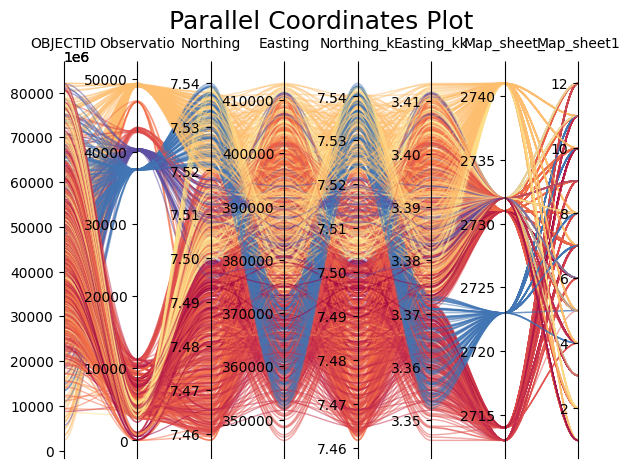

In [13]:
fig = plot_parallel_coordinates(till_geochem, "Year")

5. Fuzzy logic modeling

In [18]:
# 5.a. Transform
arrays_to_stack = []
for raster_array, meta in unified_rasters:
    out_array = _sigmoid_transform(raster_array, (0, 1), 1, True)
    arrays_to_stack.append(out_array)

transformed_arrays_for_fuzzy = np.stack(arrays_to_stack)

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]],


       [[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0

6. Weights of evidence modeling

In [ ]:
# Calculate weights
evidential_raster = rasterio.open("../tests/data/remote/workflow_demo/Discretized_data/Rcls_Dist_Strucs.tif")
deposits = geopandas.read_file("../tests/data/remote/workflow_demo/Discretized_data/IOCG_Deps_Prosp_Occs_2.shp")

df, arrays, meta, _, _ = weights_of_evidence_calculate_weights(evidential_raster=evidential_raster, deposits=deposits, weights_type="descending")

In [ ]:
weights_of_evidence_calculate_responses()